# NGC2264

In [1]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.rc('text', usetex=True)

INFO: Auto-setting vmin to  1.266e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.077e+22 [aplpy.core]


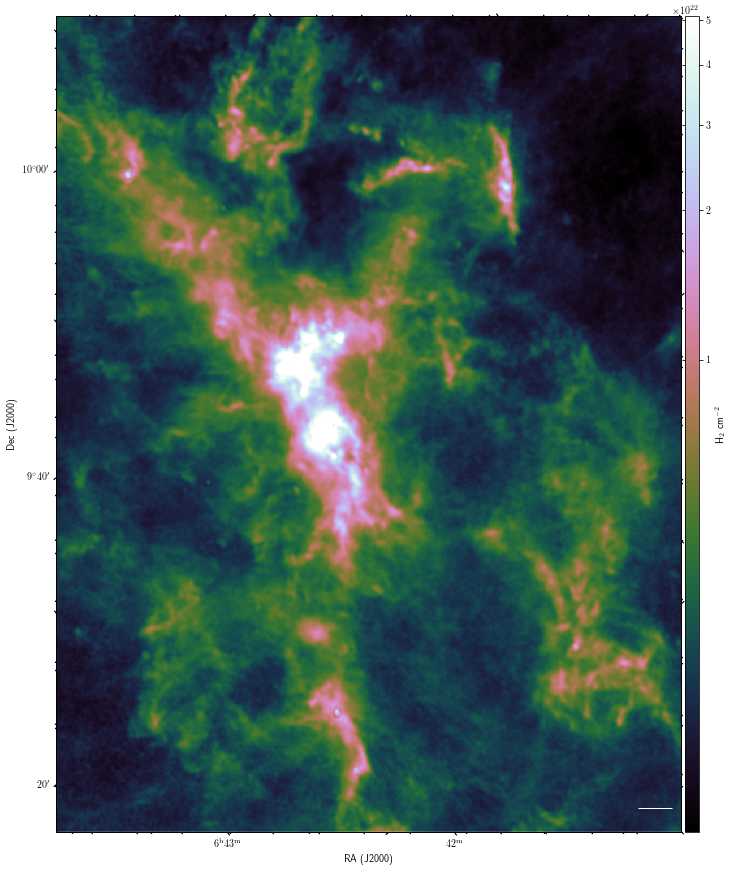

In [12]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/new/hires.02.surfden.r18p2as.cut.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.add_scalebar(2.8/60.,color='white')

In [6]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [7]:
from pywavan import fan_trans, apodize, padding, depad, powspec, gauss_beam

## Fourier Power Spectrum

5.690476190476174


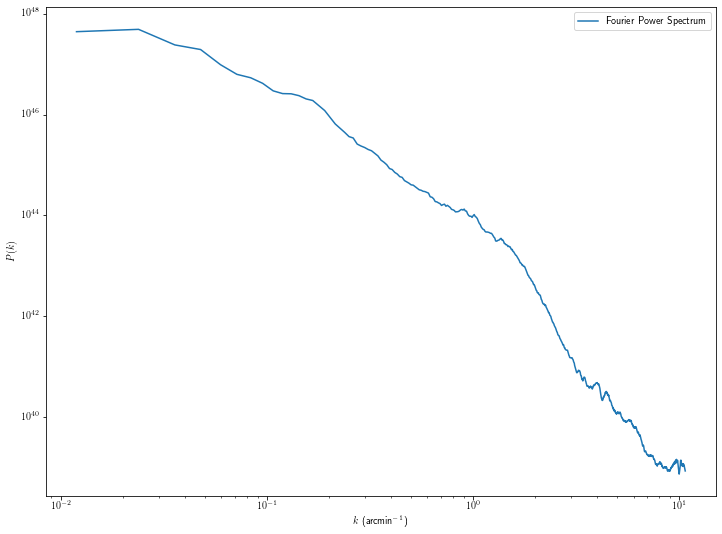

In [8]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
newdim = np.array((1800,1800))
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

noise = spec_k[477]
print(tab_k[477])

#Plot Fourier power spectrum
figure(figsize=(12,9))
plot(tab_k,spec_k, label="Fourier Power Spectrum")
xscale('log')
yscale('log')
xlabel(r"$k$ (arcmin$^{-1}$)")
ylabel(r"$P(k)$")
legend()

## Run MnGSeg

In [281]:
#Set a list of q
q=[]
q=[2.5]*26

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=True)
#print q

1800 1800


In [9]:
wt=np.load('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264src_wt.npy')
S11a=np.load('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264src_S11a.npy')
wav_k=np.load('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264src_wav_k.npy')
S1a=np.load('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264src_S1a.npy')
q=np.load('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264src_q.npy')

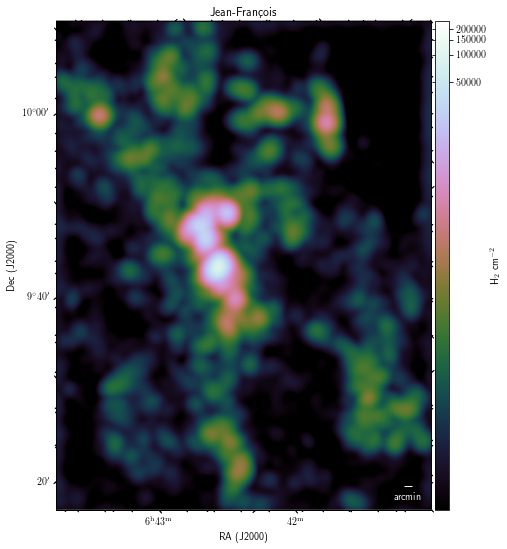

In [30]:
scl=15
fits.writeto('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_scl.fits',\
            S11a[scl,:,:]/1e21**2.,header,overwrite=True)
fig_all = plt.figure(1, figsize=(9,9))
fig = aplpy.FITSFigure('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_scl.fits',figure=fig_all)
fig.show_colorscale(stretch='log',vmin=0.68,vmax=246394,vmid=0,cmap='cubehelix')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.add_scalebar(1./(wav_k[scl]*60.),color='white', label='arcmin')
fig.set_title(r'Jean-Fran\c{c}ois')

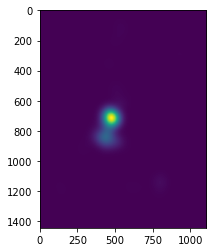

In [26]:
imshow(S11a[12,:,:])

## Image Reconstruction

In [10]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264src_cohe.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264src_gaussian.fits',\
            Gaussian.real,header,overwrite=True)

INFO: Auto-setting vmin to -4.270e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.389e+22 [aplpy.core]
INFO: Auto-setting vmin to -8.604e+21 [aplpy.core]
INFO: Auto-setting vmax to  3.826e+22 [aplpy.core]


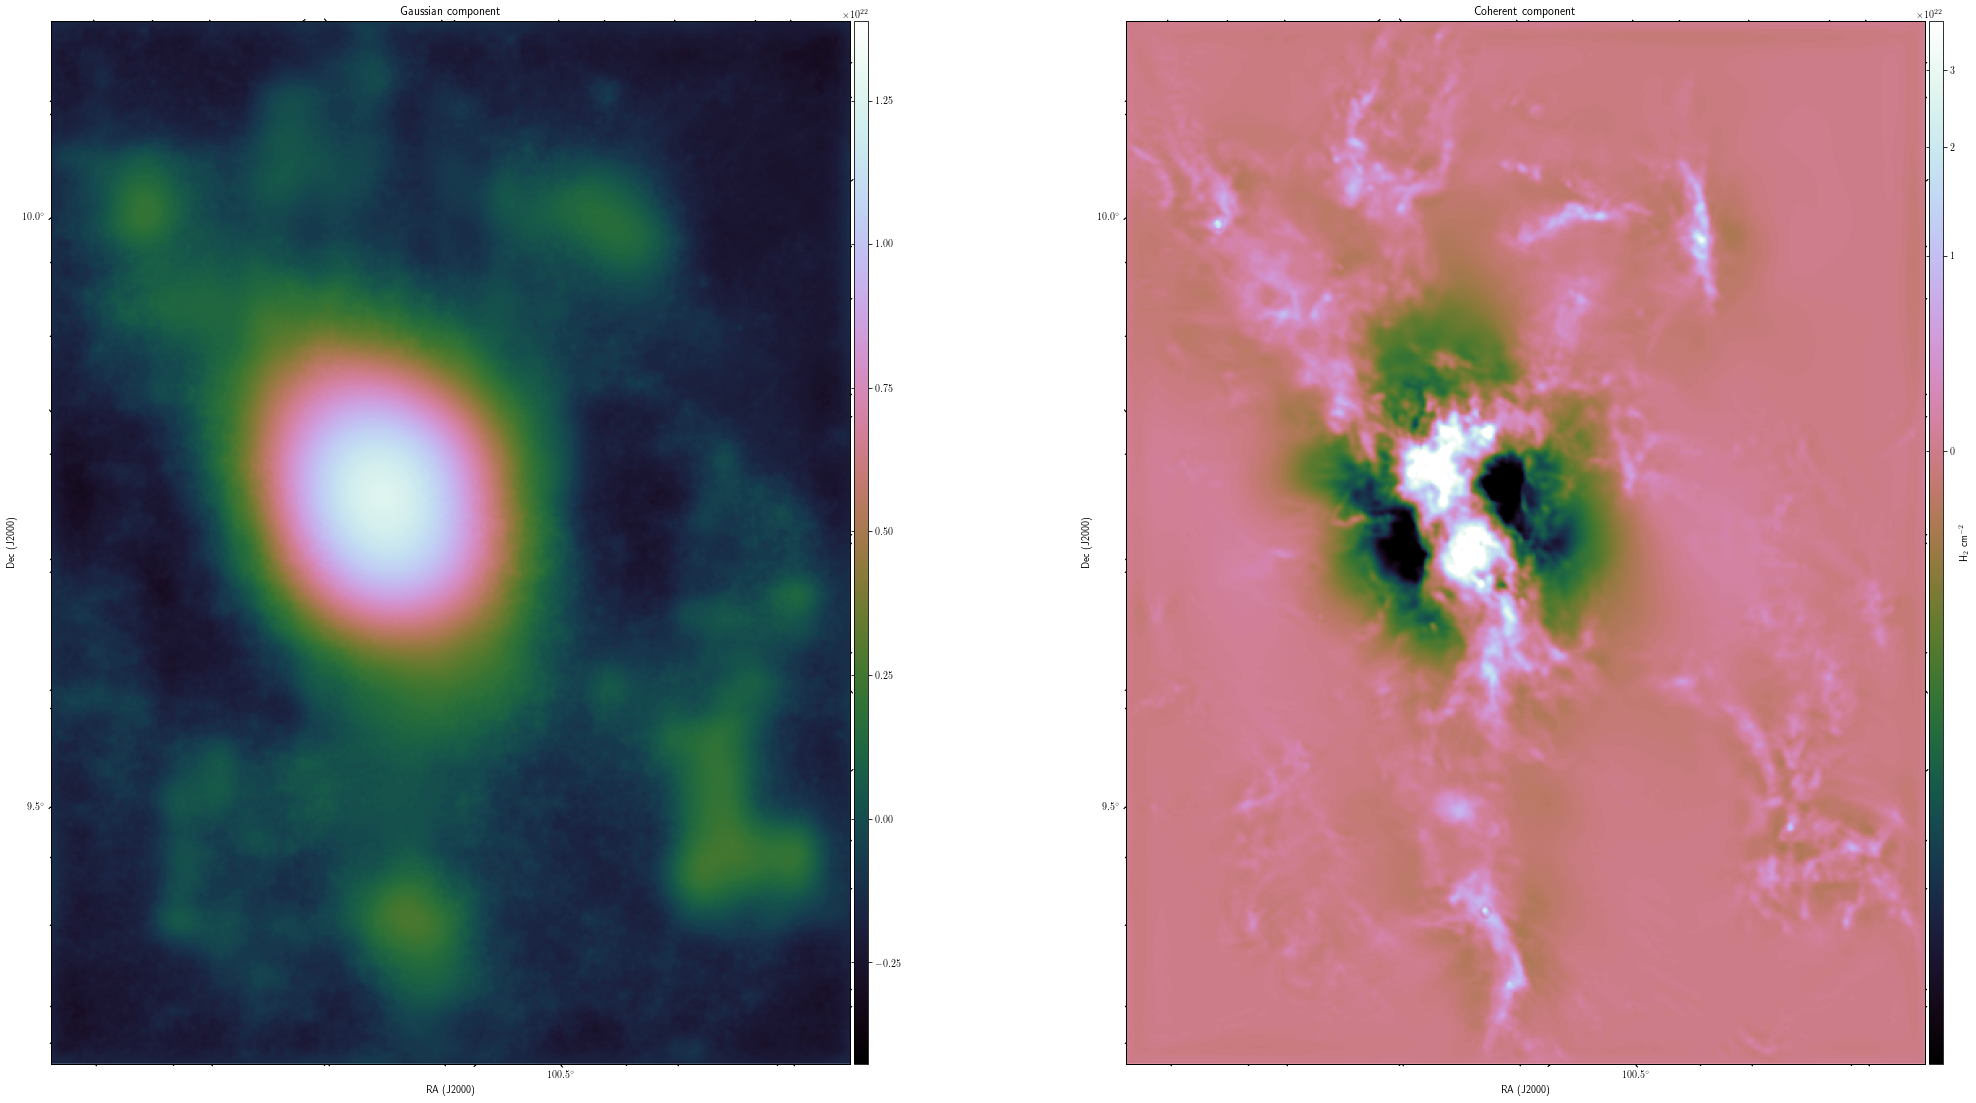

In [13]:
fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264src_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.set_title('Gaussian component')

figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264src_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.set_title('Coherent component')

plt.tight_layout()

## Segmented power spectra

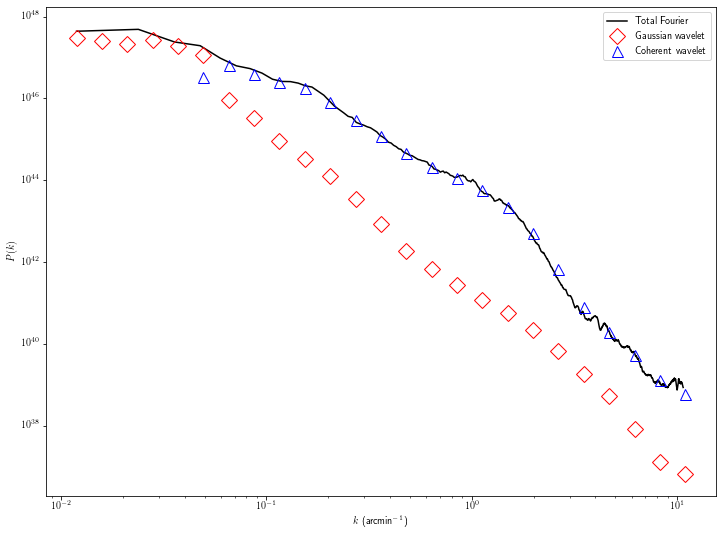

In [14]:
plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='black',label=r'Total Fourier')
plt.plot(wav_k[:-1], S1a[2,:-1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k[:-1], S1a[1,:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

### Alternative reconstruction

In [25]:
M = wav_k.shape[0]

coherent = np.sum(wt[M+6:2*M,:,:],axis=0) + np.sum(wt[0:6,:,:],axis=0)  + meanim
coherent2 = np.sum(wt[M+6:2*M,:,:],axis=0) + np.sum(wt[0:6,:,:],axis=0) + np.sum(wt[2*M+19:3*M,:,:],axis=0) + meanim
Gaussian = np.sum(wt[2*M+6:3*M,:,:],axis=0) + meanim

fits.writeto('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_coheB.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_coheB_noise.fits',\
            coherent2.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_gaussianB.fits',\
            Gaussian.real,header,overwrite=True)

INFO: Auto-setting vmin to  2.073e+21 [aplpy.core]
INFO: Auto-setting vmax to  6.663e+21 [aplpy.core]
INFO: Auto-setting vmin to -3.880e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.832e+23 [aplpy.core]


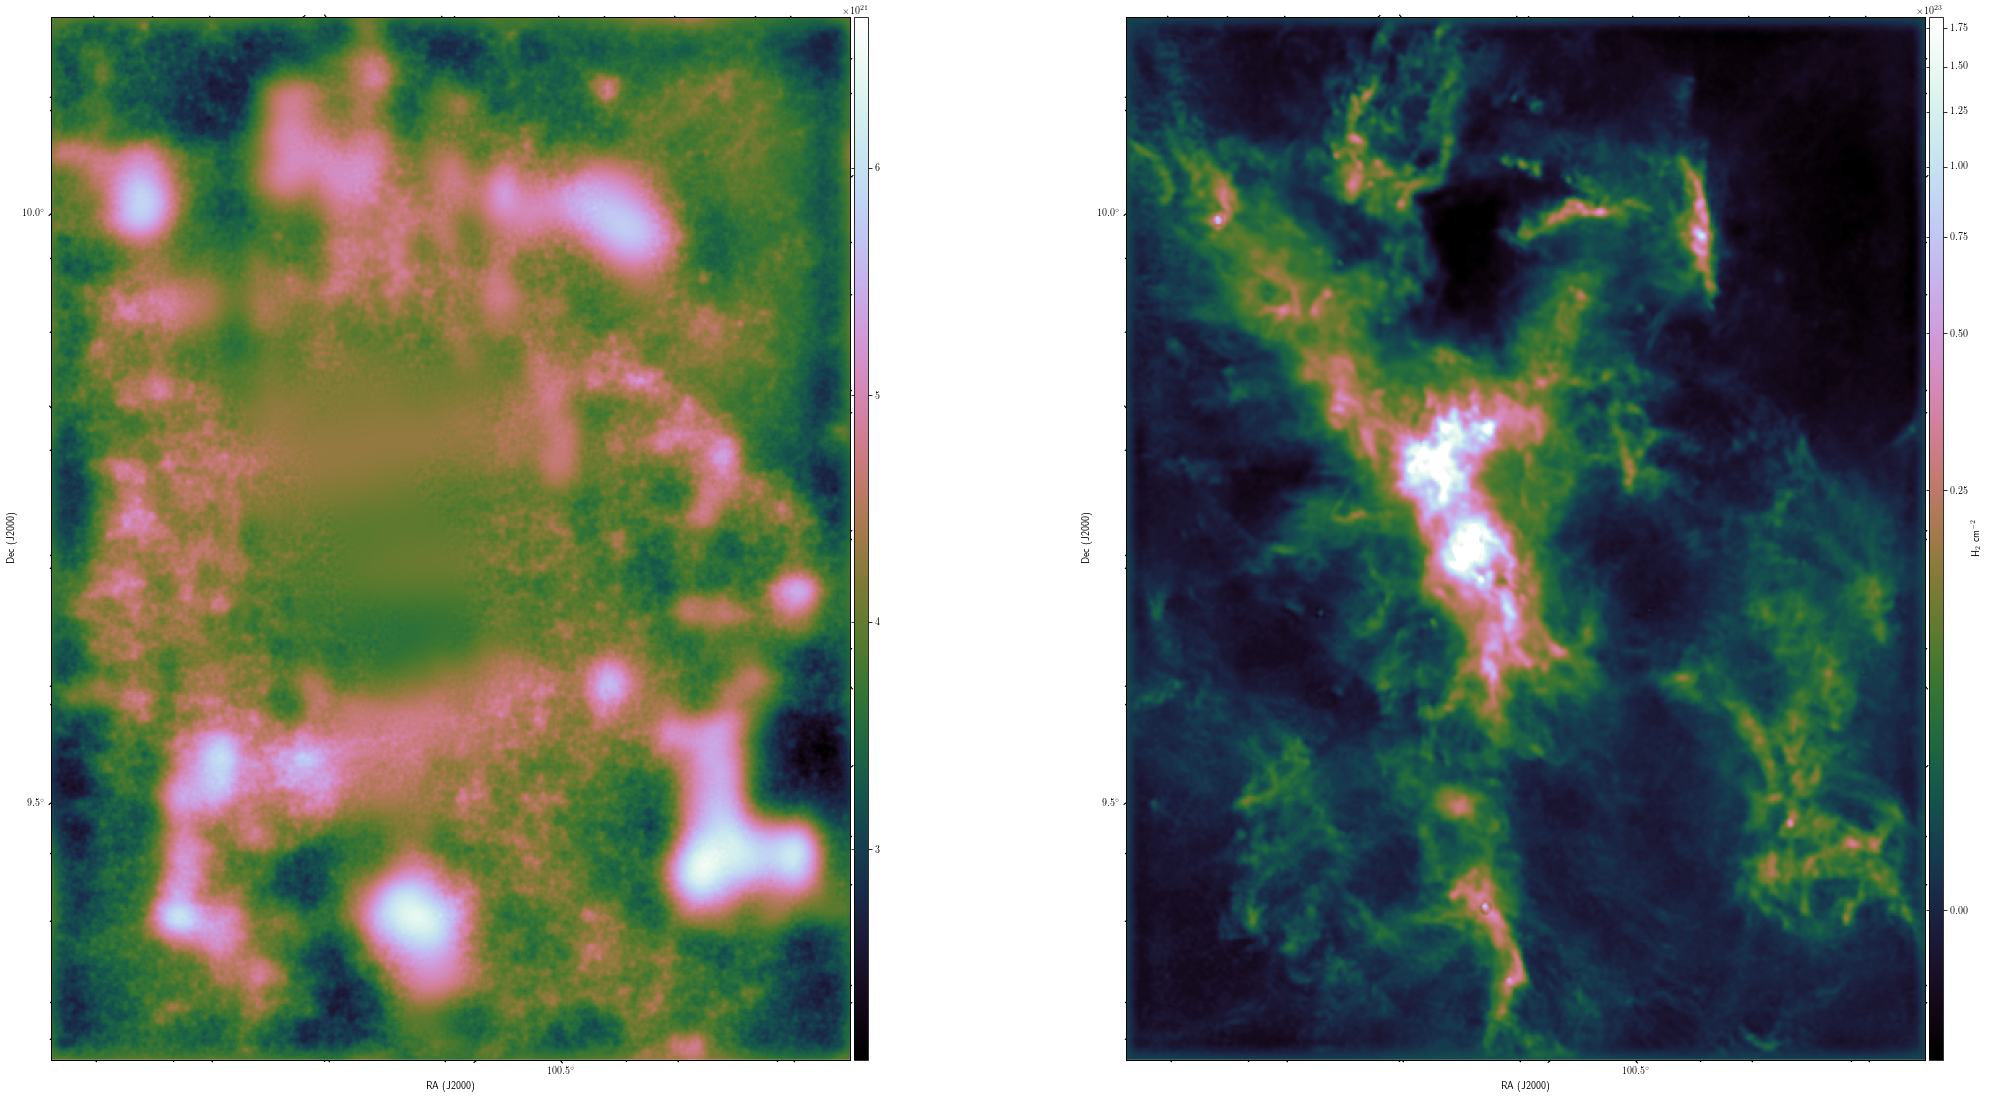

In [19]:
fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_gaussianB.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_coheB.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

tight_layout()

INFO: Auto-setting vmin to  1.080e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.285e+22 [aplpy.core]


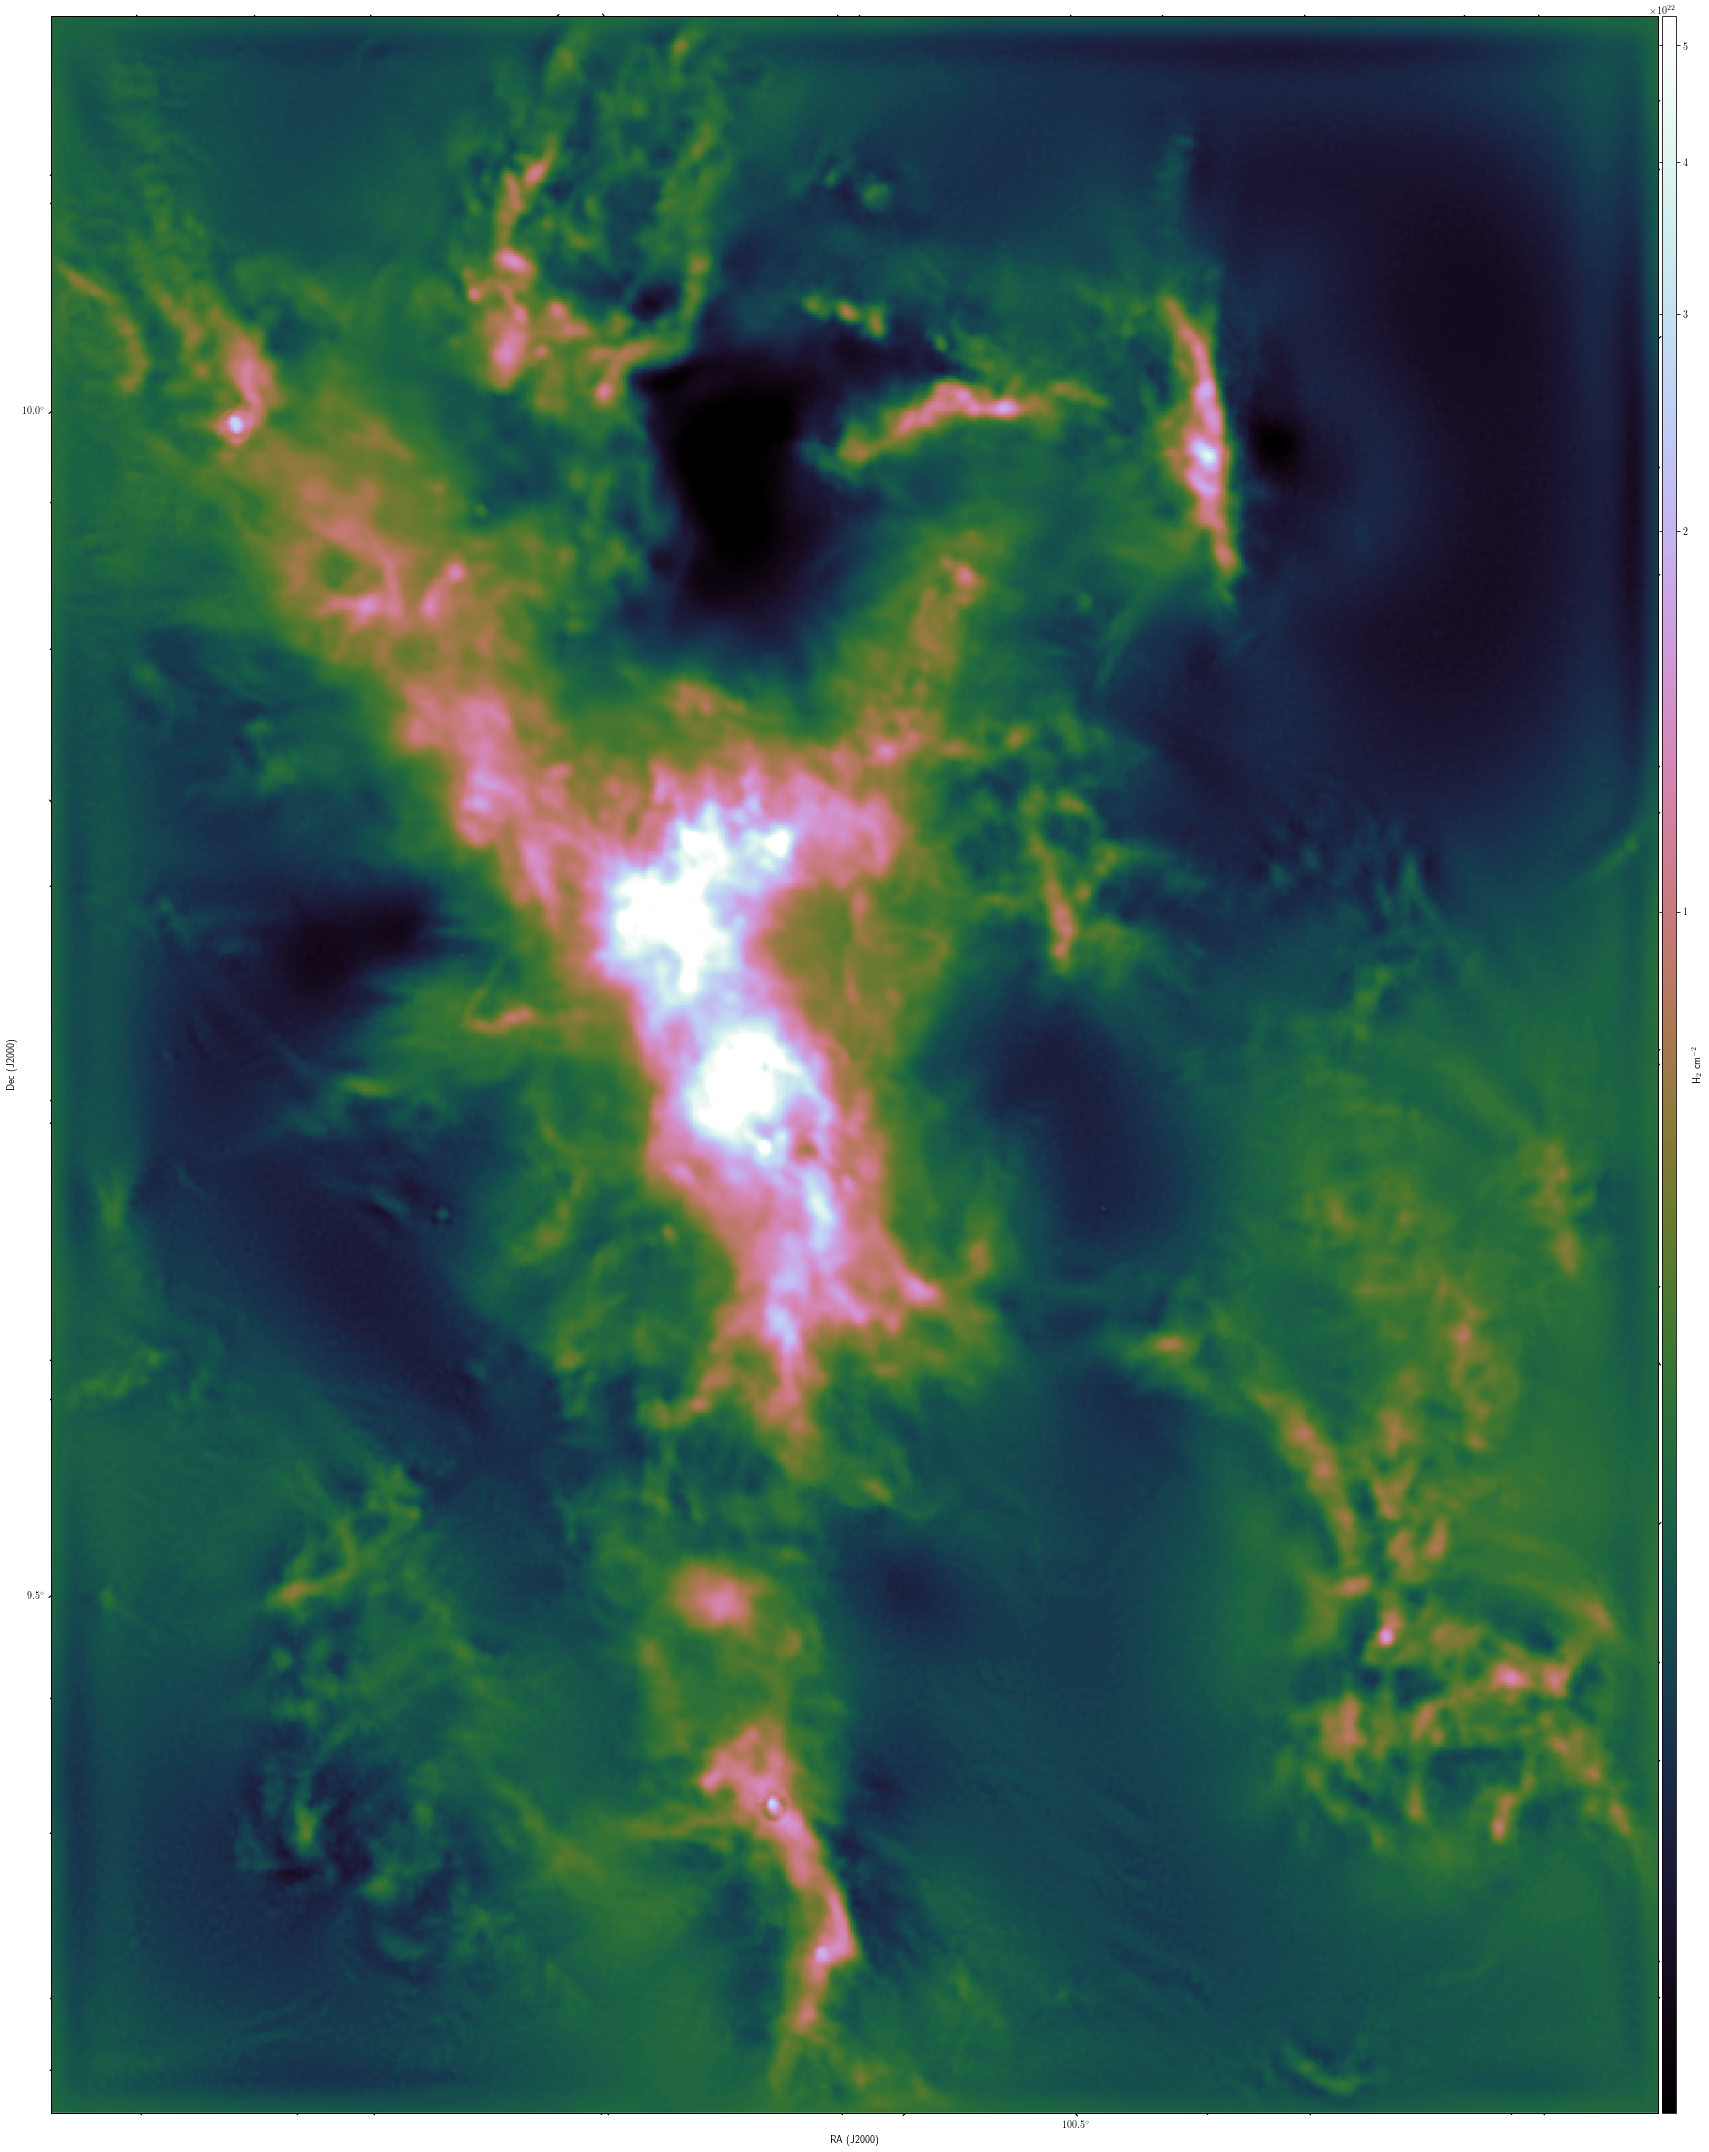

In [26]:
fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/NGC2264/analysis/NGC2264_coheB_noise.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta')
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

tight_layout()